# Implementation of Piegari et al. 2024 algorithm

In [4]:
import pandas as pd

In [108]:
# Import Bedretto M0 experiment provisional dataset 
catalog = pd.read_csv('seiscomp-exp-dd_20240415.csv')
catalog_xyz = catalog[['x', 'y', 'z']]
X = catalog_xyz.to_numpy()

## DBSCAN to detect large clusters

Choose eps and min_samples such that there is less than 60% noise points and the largest cluster contains 
less than 60% of the points. (Piegari 2024)

"before applying DBSCAN, we translated the horizontal coordinates to the hypocenter depth range (2.3 – 21.3 km) using the min-max scaling, which allowed us to consider the spatial anisotropy of the distribution"

In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [106]:
def dbscan_clustering_and_plot(X, eps, min_samples, plot=False):
    """
    Perform DBSCAN clustering on a 3D point cloud and return clusters of points.
    
    Parameters:
    X : array-like, shape (n_samples, 3)
        The original 3D point set.
    eps : float
        The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    min_samples : int
        The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
    plot : bool
        If True, plot the clusters.

    Returns:
    clusters : list of arrays
        A list where each element is a set of points corresponding to a cluster of points in X.
    """
    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    
    # Get unique labels
    unique_labels = set(labels)
    
    # Initialize clusters as list of sets
    clusters = [set() for _ in unique_labels if _ != -1]  # Exclude noise (-1)
    
    # Populate clusters with points from X
    for point_idx, label in enumerate(labels):
        if label != -1:
            clusters[label].add(tuple(X[point_idx]))
    
    # Plot the clusters if plot=True
    if plot:
        plot_clusters_3d(X, labels)
    
    return clusters

def plot_clusters_3d(X, labels):
    """
    Plot the clusters of points in 3D space.

    Parameters:
    X : array-like, shape (n_samples, 3)
        The original 3D point set.
    labels : array-like, shape (n_samples,)
        The cluster labels assigned by DBSCAN clustering.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = 'k'  # Black for noise
        mask = labels == label
        ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c=[color], label=f'Cluster {label}', s=10)

    

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

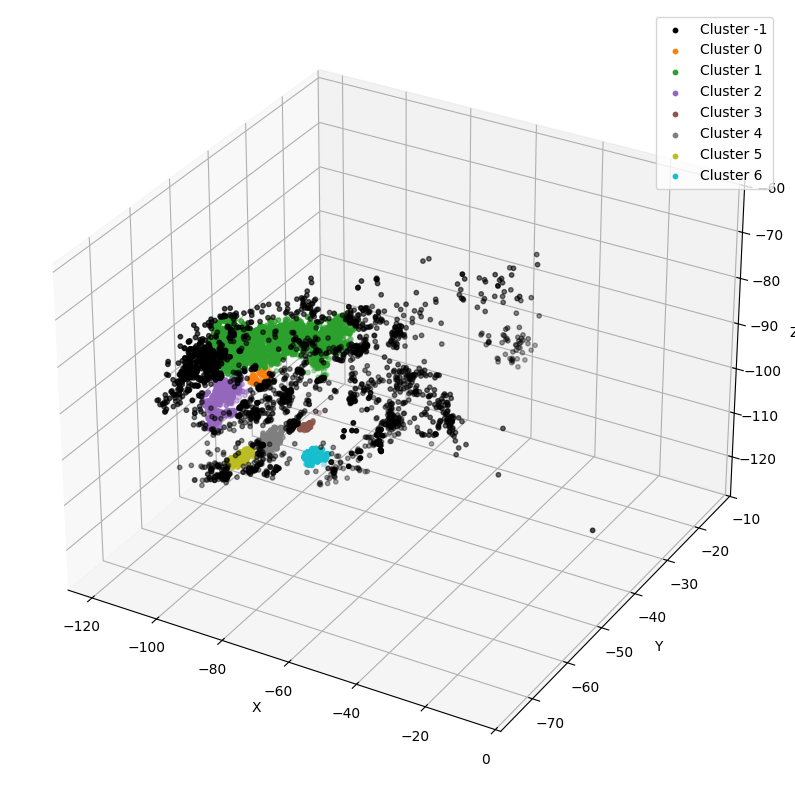

In [109]:
#e=1.2, min=50
clusters = dbscan_clustering_and_plot(X, eps = 2, min_samples = 100, plot=True)

In [91]:
len(clusters[1])/len(X)

0.4985648321477599

In [80]:
len(clusters[-1])/len(X)

0.029327343067515287

## Plane detection using PCA

Piegari : lambda3 at most half as small as lambda 1 and lambda 2

In [143]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [144]:
def compute_first_three_pcs(X):
    """
    Compute the first three principal components (PC1, PC2, and PC3) of a 3D point set.
    
    Parameters:
    X : array-like, shape (n_samples, 3)
        The original 3D point set.
    
    Returns:
    pcs : array, shape (3, 3)
        The first three principal components. Each row represents a principal component.
    """
    # Normalize the data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=3)
    pca.fit(X)
    
    # Get the first three principal components
    pcs = pca.components_

    # Get the corresponding eigenvalues
    eigenvalues = pca.explained_variance_
    
    return pcs, eigenvalues


In [114]:
cluster_1 = np.array(list(clusters[1]))

In [116]:
cluster_2 = np.array(list(clusters[2]))

In [131]:
len(cluster_2)

760

In [145]:
pcs_1, eigenvalues_1 = compute_first_three_pcs(cluster_1)

In [146]:
eigenvalues_1

array([56.75765128, 12.16773424,  0.58708842])

In [147]:
pcs_2, eigenvalues_2 = compute_first_three_pcs(cluster_2)
eigenvalues_2

array([8.92330949, 2.29126549, 0.17378046])

## OPTICS applied to plane to investigate its internal hierarchy

OPTICS (Ordering Points To Identify the Clustering Structure) is a density-based clustering algorithm that extends DBSCAN (Density-Based Spatial Clustering of Applications with Noise). It aims to identify clusters of varying shapes and sizes in datasets with noise and outliers

In [124]:
from sklearn.cluster import OPTICS

In [125]:
def apply_optics(X, min_samples, eps):
    """
    Apply OPTICS clustering algorithm to a 3D point cloud.

    Parameters:
    X : array-like, shape (n_samples, 3)
        The 3D point cloud.
    min_samples : int
        The minimum number of samples in a neighborhood for a point to be considered as a core point.
    eps : float
        The maximum distance between two samples for one to be considered as in the neighborhood of the other.

    Returns:
    labels : array-like, shape (n_samples,)
        Cluster labels for each point. Noisy samples are given the label -1.
    reachability_distances : array-like, shape (n_samples,)
        The reachability distance of each point is the max of their core distance and the distance between the two points
        (core distance is the distance to the min samples th nearest neighbor)
    reachability_plot : array-like, shape (n_samples,)
        The reachability plot (reachability distances sorted in descending order).
    """
    # Initialize OPTICS
    optics = OPTICS(min_samples=min_samples, max_eps=eps, metric='euclidean')
    
    # Fit the data and predict clusters
    optics.fit(X)
    labels = optics.labels_
    reachability_distances = optics.reachability_
    reachability_plot = optics.ordering_

    return labels, reachability_distances, reachability_plot

# Function to plot reachability plot
def plot_reachability(reachability_plot):
    """
    Plot the reachability plot obtained from OPTICS.

    Parameters:
    reachability_plot : array-like, shape (n_samples,)
        The reachability plot (reachability distances sorted in descending order).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(reachability_plot, marker='o', linestyle='-', color='b')
    plt.title('Reachability Plot')
    plt.xlabel('Data Points')
    plt.ylabel('Reachability Distance')
    plt.grid(True)
    plt.show()


In [132]:
labels, reachability_distances, reachability_plot = apply_optics(cluster_2, min_samples=10, eps=1)

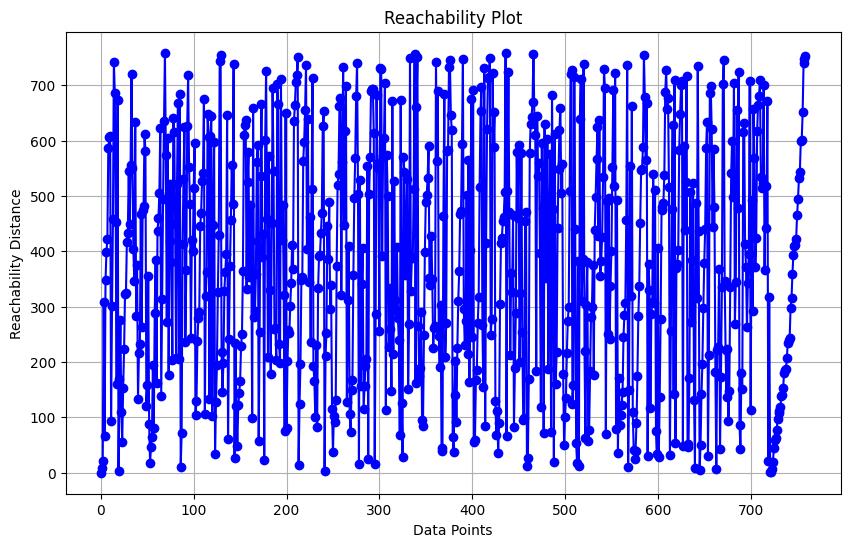

In [133]:

plot_reachability(reachability_plot)

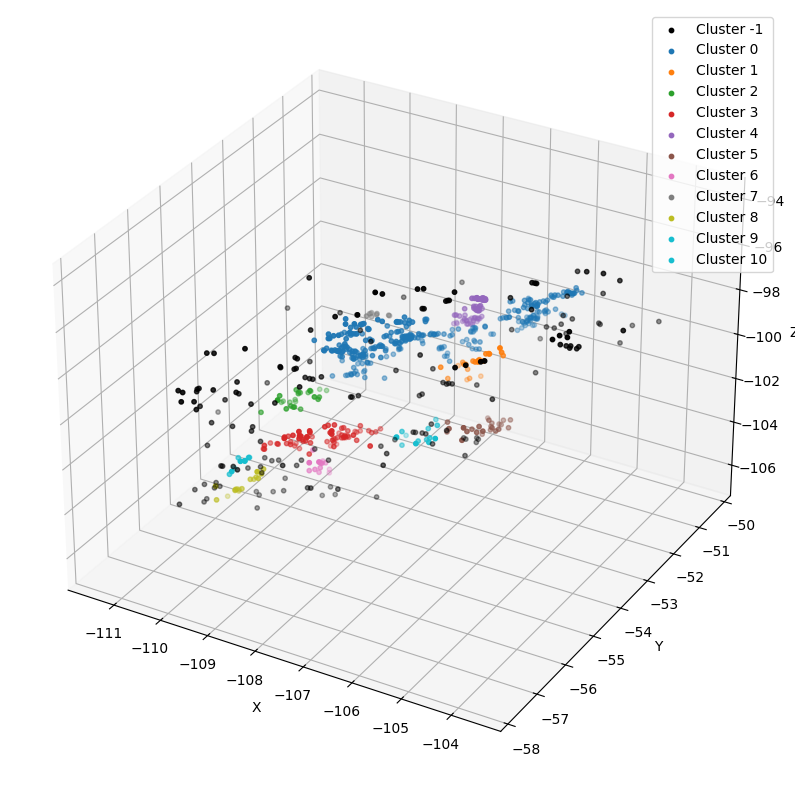

In [137]:
# Reapply DBSCAN to cluster 2
sub_clusters = dbscan_clustering_and_plot(cluster_2, eps = 0.5, min_samples = 10, plot=True)

In [138]:
len(sub_clusters[0])/len(cluster_2)

0.4276315789473684

In [139]:
len(sub_clusters[-1])/len(cluster_2)

0.013157894736842105

In [140]:
sub_cluster_0 = np.array(list(sub_clusters[0]))

In [141]:
sub_pcs_0, sub_eigenvalues_0 = compute_first_three_pcs(sub_cluster_0)
sub_eigenvalues_0

array([2.02240174, 0.86838092, 0.01344384])

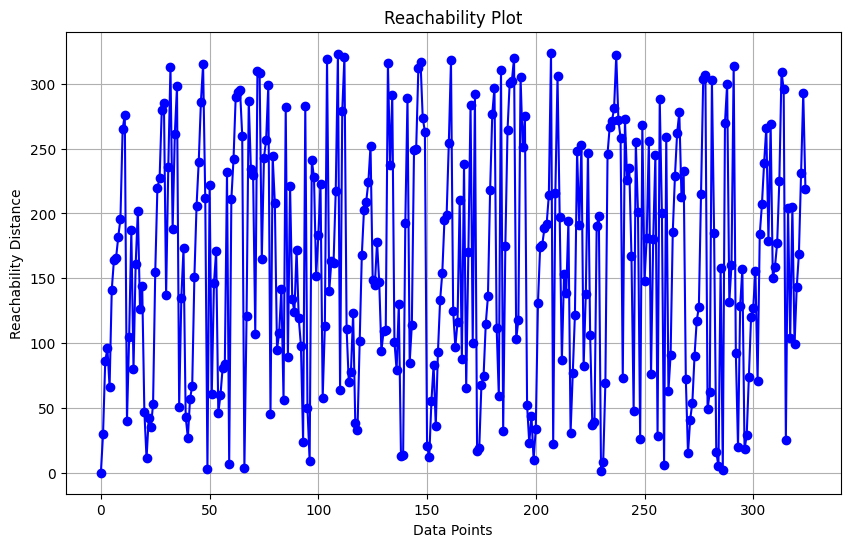

In [142]:
sub_labels, sub_reachability_distances, sub_reachability_plot = apply_optics(sub_cluster_0, min_samples=10, eps=0.5)
plot_reachability(sub_reachability_plot)

## Algorithm

Parameters : DBSCAN eps, min points, OPTICS eps, min points, PCA threshold to separate lambda3

In [130]:
# Compute DBSCAN clusters

# For each cluster:
    # If eigenvalue3 << eigenvalues 1&2:
        # Select plane 
    # Else:
       # Make OPTICS reachability plot : denser regions appear as valleys whose depth and width 
       # give information about the density and the spatial extension of the denser nested regions, respectively
            
            # If valleys (ie dense regions ) to investigate:
                # Go back to DBSCAN step
            # Else:
                # Stop

# Return planar cluster and noise